<h1>Implementación elemental del algoritmo de Shor</h1>

<h2>Imports</h2>

In [1]:
# Import numerical calculation library
import numpy as np
from numpy import pi

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, assemble, transpile, execute, QuantumRegister, ClassicalRegister

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector

<h2>Funciones auxiliares</h2>

In [2]:
def count_gates(qc: QuantumCircuit):
    total_gates = 0
    for qubit in qc.data:
        total_gates += 1
    return total_gates

<h2>Aritmética elemental</h2>

<h3>Sumador de N qubits</h3>

In [3]:
# Elementos basicos para la suma de N qubits
qc_carry = QuantumCircuit(4, name = "carry")
qc_carry.ccx(1,2,3)
qc_carry.cx(1,2)
qc_carry.ccx(0,2,3)
print("carry: ", qc_carry)

qc_sum = QuantumCircuit(3, name = "sum")
qc_sum.cx(1,2)
qc_sum.cx(0,2)
print("sum: ", qc_sum)

carry:                      
q_0: ────────────■──
                 │  
q_1: ──■────■────┼──
       │  ┌─┴─┐  │  
q_2: ──■──┤ X ├──■──
     ┌─┴─┐└───┘┌─┴─┐
q_3: ┤ X ├─────┤ X ├
     └───┘     └───┘
sum:                 
q_0: ───────■──
            │  
q_1: ──■────┼──
     ┌─┴─┐┌─┴─┐
q_2: ┤ X ├┤ X ├
     └───┘└───┘


In [4]:
# Sumador de N qubits
# Entrada --> a0..an b0..bn c0..cn
# Salida --> a0..an (a+b)0..(a+b)n+1 c1..cn
def createAdder(n):
    qr_a = QuantumRegister(n,'a')
    qr_b = QuantumRegister(n+1,'b')
    qr_c = QuantumRegister(n,'c')
    qc_carry_dg = qc_carry.inverse()
    qc_adder = QuantumCircuit(qr_a, qr_b, qr_c, name = "adder-"+str(n))
    for i in range(n-1):
        qc_adder.append(qc_carry, [2*n+1+i, i, n+i, 2*n+1+i+1])
    qc_adder.append(qc_carry, [3*n, n-1, 2*n-1, 2*n])
    
    qc_adder.cx(n-1, 2*n-1)
    qc_adder.append(qc_sum, [3*n, n-1, 2*n-1])
    
    for i in range(n-2,-1,-1):
        qc_adder.append(qc_carry_dg, [2*n+1+i, i, n+i, 2*n+1+i+1])
        qc_adder.append(qc_sum, [2*n+1+i, i, n+i])
        
    return qc_adder
    
qc_adder = createAdder(2)
print(qc_adder)

     ┌────────┐                       ┌───────────┐┌──────┐
a_0: ┤1       ├───────────────────────┤1          ├┤1     ├
     │        │┌────────┐     ┌──────┐│           ││      │
a_1: ┤        ├┤1       ├──■──┤1     ├┤           ├┤      ├
     │        ││        │  │  │      ││           ││      │
b_0: ┤2       ├┤        ├──┼──┤      ├┤2          ├┤2     ├
     │        ││        │┌─┴─┐│      ││           ││  sum │
b_1: ┤  carry ├┤2       ├┤ X ├┤2     ├┤  carry_dg ├┤      ├
     │        ││  carry │└───┘│  sum ││           ││      │
b_2: ┤        ├┤3       ├─────┤      ├┤           ├┤      ├
     │        ││        │     │      ││           ││      │
c_0: ┤0       ├┤        ├─────┤      ├┤0          ├┤0     ├
     │        ││        │     │      ││           │└──────┘
c_1: ┤3       ├┤0       ├─────┤0     ├┤3          ├────────
     └────────┘└────────┘     └──────┘└───────────┘        


In [5]:
# Prueba del sumador de N qubits
qr_a = QuantumRegister(5,'a')
qr_b = QuantumRegister(5+1,'b')
qr_c = QuantumRegister(5,'c')
cr = ClassicalRegister(6, 'suma')
qc_suma = QuantumCircuit(qr_a, qr_b, qr_c,cr)
# A = 01101 = 13
qc_suma.x(0)
qc_suma.x(2)
qc_suma.x(3)
# B = 11001 = 25
qc_suma.x(5)
qc_suma.x(8)
qc_suma.x(9)

qc_suma.append(createAdder(5), range(16))
for i in range(6):
    qc_suma.measure(5+i,i)
# Resultado esperado = A + B = 13 + 25 = 38 = 100110
print(qc_suma)

        ┌───┐┌───────────┐                  
   a_0: ┤ X ├┤0          ├──────────────────
        └───┘│           │                  
   a_1: ─────┤1          ├──────────────────
        ┌───┐│           │                  
   a_2: ┤ X ├┤2          ├──────────────────
        ├───┤│           │                  
   a_3: ┤ X ├┤3          ├──────────────────
        └───┘│           │                  
   a_4: ─────┤4          ├──────────────────
        ┌───┐│           │┌─┐               
   b_0: ┤ X ├┤5          ├┤M├───────────────
        └───┘│           │└╥┘┌─┐            
   b_1: ─────┤6          ├─╫─┤M├────────────
             │           │ ║ └╥┘┌─┐         
   b_2: ─────┤7          ├─╫──╫─┤M├─────────
        ┌───┐│   adder-5 │ ║  ║ └╥┘┌─┐      
   b_3: ┤ X ├┤8          ├─╫──╫──╫─┤M├──────
        ├───┤│           │ ║  ║  ║ └╥┘┌─┐   
   b_4: ┤ X ├┤9          ├─╫──╫──╫──╫─┤M├───
        └───┘│           │ ║  ║  ║  ║ └╥┘┌─┐
   b_5: ─────┤10         ├─╫──╫──╫──╫──╫─┤M├
          

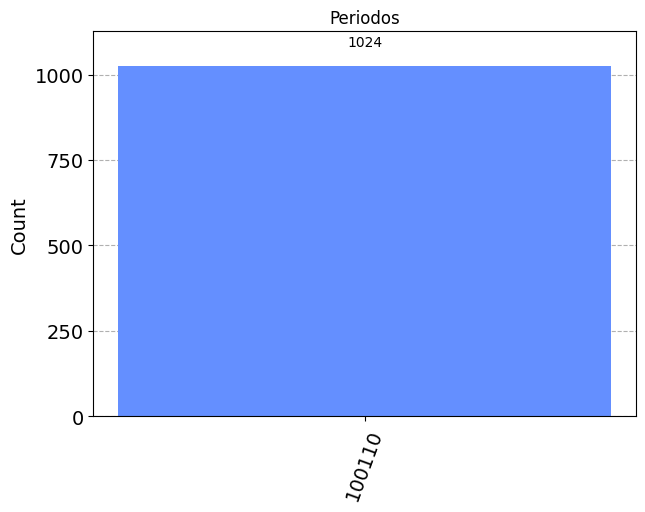

In [6]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator')
qc_suma_transpiled = transpile(qc_suma, simulator)

# Run and get counts
result = simulator.run(qc_suma_transpiled).result()
counts = result.get_counts(qc_suma_transpiled)
plot_histogram(counts, title='Periodos')

<h3>Sumador modular</h3>

Sumador modular - Versión inspirada por V. Vedral, A. Barenco y A. Ekert.

Problema: solo funciona si 2*M > a + b, es decir, M debe tener por lo menos n cifras significativas para funcionar para cualquier valor de a y b.

In [7]:
# Sumador de N qubits modulo M
# Entrada --> a[0]..an b[0]..bn aux[0]..aux[2*n+2]
# Salida --> a[0]..an [(a+b) mod M][0]..[(a+b) mod M][n] aux[0]..aux[2*n+2]
def createModAdderVedral(n, M):
    qr_a = QuantumRegister(n,'a')
    qr_b = QuantumRegister(n,'b')
    qr_m = QuantumRegister(n,'M')
    qr_c = QuantumRegister(n+1,'c')
    qr_o = QuantumRegister(1,'o')
    
    # Circuitos que usaremos
    qc_adder = createAdder(n)
    qc_subtractor = qc_adder.inverse()

    # Creamos el circuito
    qc_mod_adder = QuantumCircuit(qr_a, qr_b, qr_m, qr_c, qr_o, name = "adder-"+str(n)+" mod "+str(M))

    # Inicializamos M
    m = M
    for i in range(n):
        if m % 2 == 1:
            qc_mod_adder.x(2*n+i)
        m = m // 2
    
    # Sumamos a y b (resultado --> [n-2n, 3*n+1])
    qc_mod_adder.append(qc_adder, list(range(2*n)) + list(range(3*n,4*n+1)))

    # Restamos al resultado M
    qc_mod_adder.append(qc_subtractor, list(range(2*n, 3*n)) + list(range(n, 2*n))+ list(range(3*n,4*n+1)))

    # Guardamos el overflow
    qc_mod_adder.x(3*n)
    qc_mod_adder.cx(3*n,4*n+1)
    qc_mod_adder.x(3*n)

    # Limpiamos el registro M si hay overflow
    m = M
    for i in range(n):
        if m % 2 == 1:
            qc_mod_adder.cx(4*n+1, 2*n+i)
        m = m // 2

    # Sumamos al resultado el registro M
    qc_mod_adder.append(qc_adder, list(range(2*n, 3*n)) + list(range(n, 2*n))+ list(range(3*n,4*n+1)))

    # Recuperamos el registro M
    m = M
    for i in range(n):
        if m % 2 == 1:
            qc_mod_adder.cx(4*n+1, 2*n+i)
        m = m // 2
    qc_mod_adder.barrier()
    # Deshacemos la suma inicial para obtener el valor del acarreo
    qc_mod_adder.append(qc_subtractor, list(range(2*n)) + list(range(3*n,4*n+1)))
    
    qc_mod_adder.cx(3*n,4*n+1)

    # Realizamos finalmente la suma
    qc_mod_adder.append(qc_adder, list(range(2*n)) + list(range(3*n,4*n+1)))

    # Deshacemos M
    m = M
    for i in range(n):
        if m % 2 == 1:
            qc_mod_adder.x(2*n+i)
        m = m // 2
        
    return qc_mod_adder

print(createModAdderVedral(5, 20))

          ┌───────────┐                                                      »
a_0: ─────┤0          ├──────────────────────────────────────────────────────»
          │           │                                                      »
a_1: ─────┤1          ├──────────────────────────────────────────────────────»
          │           │                                                      »
a_2: ─────┤2          ├──────────────────────────────────────────────────────»
          │           │                                                      »
a_3: ─────┤3          ├──────────────────────────────────────────────────────»
          │           │                                                      »
a_4: ─────┤4          ├──────────────────────────────────────────────────────»
          │           │┌──────────────┐                         ┌───────────┐»
b_0: ─────┤5          ├┤5             ├─────────────────────────┤5          ├»
          │           ││              │             

In [8]:
# Prueba del sumador de N qubits
n = 5
qr_a = QuantumRegister(n,'a')
qr_b = QuantumRegister(n,'b')
qr_m = QuantumRegister(n,'m')
qr_c = QuantumRegister(n+1,'c')
qr_o = QuantumRegister(1,'o')
cr = ClassicalRegister(n, 'suma')
qc_suma_mod = QuantumCircuit(qr_a, qr_b, qr_m, qr_c, qr_o, cr)
# A = 01101 = 13
qc_suma_mod.x(0)
qc_suma_mod.x(2)
qc_suma_mod.x(3)
# B = 11001 = 25
qc_suma_mod.x(5)
qc_suma_mod.x(8)
qc_suma_mod.x(9)
qc_suma_mod.append(createModAdderVedral(n, 20),range(4*n+2))

for i in range(n):
    qc_suma_mod.measure(n+i,i)
# Resultado esperado = A + B = 13 + 25 mod 10 = 8 = 1000
print(qc_suma_mod)

        ┌───┐┌──────────────────┐               
   a_0: ┤ X ├┤0                 ├───────────────
        └───┘│                  │               
   a_1: ─────┤1                 ├───────────────
        ┌───┐│                  │               
   a_2: ┤ X ├┤2                 ├───────────────
        ├───┤│                  │               
   a_3: ┤ X ├┤3                 ├───────────────
        └───┘│                  │               
   a_4: ─────┤4                 ├───────────────
        ┌───┐│                  │┌─┐            
   b_0: ┤ X ├┤5                 ├┤M├────────────
        └───┘│                  │└╥┘┌─┐         
   b_1: ─────┤6                 ├─╫─┤M├─────────
             │                  │ ║ └╥┘┌─┐      
   b_2: ─────┤7                 ├─╫──╫─┤M├──────
        ┌───┐│                  │ ║  ║ └╥┘┌─┐   
   b_3: ┤ X ├┤8                 ├─╫──╫──╫─┤M├───
        ├───┤│                  │ ║  ║  ║ └╥┘┌─┐
   b_4: ┤ X ├┤9                 ├─╫──╫──╫──╫─┤M├
        └───┘│      

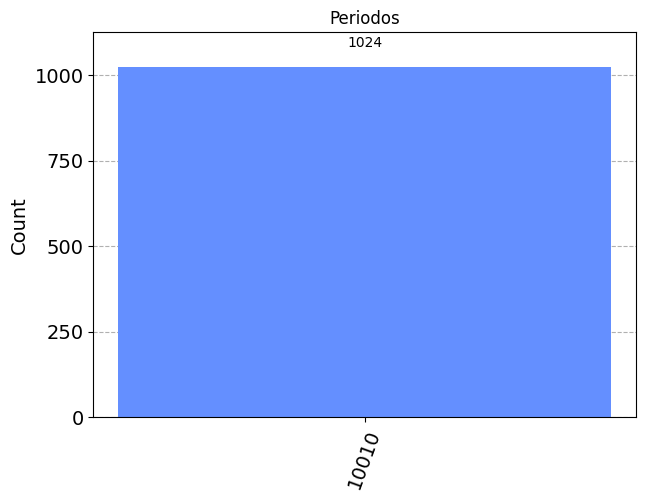

In [9]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator')
qc_suma_mod_transpiled = transpile(qc_suma_mod, simulator)

# Run and get counts
result = simulator.run(qc_suma_mod_transpiled).result()
counts = result.get_counts(qc_suma_mod_transpiled)
plot_histogram(counts, title='Periodos')

<h2>Multiplicacion modular controlada</h2>

In [10]:
# Multiplicacion de N qubits modulo M
# Entrada --> control x[0]..x[n] 0[0]..0[n] aux[0]..auxn[3*n+2]
# Salida -->  control x[0]..x[n] (x*y)[0]..(x*y)[n] aux[0]..auxn[2*n+2]

def createMult(n, y, M):
    qr_c = QuantumRegister(1,'control')
    qr_x = QuantumRegister(n,'x')
    qr_mult = QuantumRegister(n,'mult')
    qr_a = QuantumRegister(n,'a')
    qr_aux = QuantumRegister(2*n+2,'aux')
    
    # Subcircuitos que usaremos
    qc_mod_adder = createModAdderVedral(n, M)

    # Creamos el circuito
    qc_mod_mult = QuantumCircuit(qr_c, qr_x, qr_mult, qr_a, qr_aux, name = "x"+str(y)+" mod "+str(M)+"-"+str(n))

    y_act = y

    # Por cada qubit del multiplicador
    for i in range(n):
        # Si el qubit x[i] es 1 --> Sumamos 2^i*y mod M
        # Si no, sumamos 0
        # Colocamos en el registro 2^i*y o 0
        m = y_act
        for j in range(n):
            if m % 2 == 1:
                qc_mod_mult.ccx(0,i+1,2*n+1+j)
            m = m // 2

        # Realizamos la suma modular
        qc_mod_mult.append(qc_mod_adder, list(range(2*n+1, 3*n+1)) + list(range(n+1, 2*n+1)) + list(range(3*n+1,5*n+3)))
        
        # Borramos el contenido de a
        m = y_act
        for j in range(n):
            if m % 2 == 1:
                qc_mod_mult.ccx(0,i+1,2*n+1+j)
            m = m // 2
        
        # Calculamos el siguiente 2^i*y mod M
        #print(y_act)
        y_act = 2*y_act % M
        qc_mod_mult.barrier()

    # Finalmente, si detectamos que el qubit de control esta desactivado
    # Copiamos x en el resultado
    qc_mod_mult.x(0)
    for i in range(n):
        qc_mod_mult.ccx(0,i+1,n+i+1)
    qc_mod_mult.x(0)
    
    return qc_mod_mult

qc_mult = createMult(n, 7, 11)
print(qc_mult)

                                                            ░           »
control: ──■────■────■────────────────────────■────■────■───░───■────■──»
           │    │    │                        │    │    │   ░   │    │  »
    x_0: ──■────■────■────────────────────────■────■────■───░───┼────┼──»
           │    │    │                        │    │    │   ░   │    │  »
    x_1: ──┼────┼────┼────────────────────────┼────┼────┼───░───■────■──»
           │    │    │                        │    │    │   ░   │    │  »
    x_2: ──┼────┼────┼────────────────────────┼────┼────┼───░───┼────┼──»
           │    │    │                        │    │    │   ░   │    │  »
    x_3: ──┼────┼────┼────────────────────────┼────┼────┼───░───┼────┼──»
           │    │    │                        │    │    │   ░   │    │  »
    x_4: ──┼────┼────┼────────────────────────┼────┼────┼───░───┼────┼──»
           │    │    │  ┌──────────────────┐  │    │    │   ░   │    │  »
 mult_0: ──┼────┼────┼──┤5            

In [11]:
# Prueba del multiplicador de N qubits mod M
n = 4
qr_c = QuantumRegister(1,'control')
qr_x = QuantumRegister(n,'x')
qr_mult = QuantumRegister(n,'mult')
qr_aux = QuantumRegister(3*n+2,'aux')
cr = ClassicalRegister(n, 'res')
qc_prueba_mod_mult = QuantumCircuit(qr_c, qr_x, qr_mult, qr_aux, cr)

# Activamos el qubit de control
#qc_prueba_mod_mult.x(0)

# X = 1111 = 15
qc_prueba_mod_mult.x(1)
qc_prueba_mod_mult.x(2)
#qc_prueba_mod_mult.x(3)
qc_prueba_mod_mult.x(4)

qc_prueba_mod_mult.append(createMult(n, 7, 11), range(5*n+3))

for i in range(n):
    qc_prueba_mod_mult.measure(n+1+i,i)
# Resultado esperado = 15*7 mod 11 = 105 mod 11 = 6
print(qc_prueba_mod_mult)

              ┌───────────────┐            
control: ─────┤0              ├────────────
         ┌───┐│               │            
    x_0: ┤ X ├┤1              ├────────────
         ├───┤│               │            
    x_1: ┤ X ├┤2              ├────────────
         └───┘│               │            
    x_2: ─────┤3              ├────────────
         ┌───┐│               │            
    x_3: ┤ X ├┤4              ├────────────
         └───┘│               │┌─┐         
 mult_0: ─────┤5              ├┤M├─────────
              │               │└╥┘┌─┐      
 mult_1: ─────┤6              ├─╫─┤M├──────
              │               │ ║ └╥┘┌─┐   
 mult_2: ─────┤7              ├─╫──╫─┤M├───
              │               │ ║  ║ └╥┘┌─┐
 mult_3: ─────┤8              ├─╫──╫──╫─┤M├
              │               │ ║  ║  ║ └╥┘
  aux_0: ─────┤9              ├─╫──╫──╫──╫─
              │               │ ║  ║  ║  ║ 
  aux_1: ─────┤10             ├─╫──╫──╫──╫─
              │               │ 

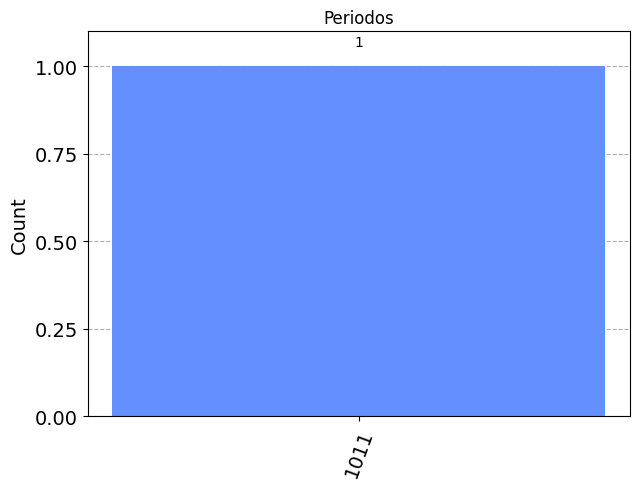

In [12]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator')
qc_prueba_mod_mult_transpiled = transpile(qc_prueba_mod_mult, simulator)

# Run and get counts
result = simulator.run(qc_prueba_mod_mult_transpiled, shots=1).result()
counts = result.get_counts(qc_prueba_mod_mult_transpiled)
plot_histogram(counts, title='Periodos')

<h2>Exponenciación modular</h2>

In [13]:
##### Multiplicacion de N qubits modulo M - Por completar
# Entrada --> exp[0..n] 0[0..n] aux[0..3*n+2]
# Salida -->  exp[0..n] (y^exp mod M)[0..n] aux[0..3*n+2]
from sympy import mod_inverse

def createExpMod(n, y, M):
    qr_x = QuantumRegister(n,'x')
    qr_mult = QuantumRegister(n,'mult')
    qr_a = QuantumRegister(n,'a')
    qr_aux = QuantumRegister(3*n+2,'aux')
    #cr = ClassicalRegister(n)
    
    # Creamos el circuito
    #qc_exp_mod = QuantumCircuit(qr_x, qr_mult, qr_a, qr_aux, cr, name = "x"+str(y)+" mod "+str(M)+"-"+str(n))
    qc_exp_mod = QuantumCircuit(qr_x, qr_mult, qr_a, qr_aux, name = "x"+str(y)+" mod "+str(M)+"-"+str(n))
    
    qc_exp_mod.x(0)
    qc_exp_mod.x(1)
    
    # Inicializamos a
    qc_exp_mod.x(n)
    
    mult_actual = y
    for i in range(0, n-1, 2):
        subcircuit = createMult(n, mult_actual, M)
        qc_exp_mod.append(subcircuit, [i]+list(range(n,6*n+2)))
        subcircuit = createMult(n,mod_inverse(mult_actual, M), M)
        qc_exp_mod.append(subcircuit.inverse(), [i]+list(range(2*n,3*n))+list(range(n,2*n))+list(range(3*n,6*n+2)))
        mult_actual = (mult_actual * mult_actual) % M
        
        subcircuit = createMult(n, mult_actual, M)
        qc_exp_mod.append(subcircuit, [i+1]+list(range(2*n,3*n))+list(range(n,2*n))+list(range(3*n,6*n+2)))
        subcircuit = createMult(n,mod_inverse(mult_actual, M), M)
        qc_exp_mod.append(subcircuit.inverse(), [i+1]+list(range(n,6*n+2)))
        mult_actual = (mult_actual * mult_actual) % M
    
    if n % 2 == 1:
        subcircuit = createMult(n, mult_actual, M)
        qc_exp_mod.append(subcircuit, [n-1]+list(range(n,6*n+2)))
        subcircuit = createMult(n,mod_inverse(mult_actual, M), M)
        qc_exp_mod.append(subcircuit.inverse(), [n-1]+list(range(2*n,3*n))+list(range(n,2*n))+list(range(3*n,6*n+2)))
        for j in range(n):
            qc_exp_mod.swap(n+j,2*n+j)
   
    #for j in range(n):
    #    qc_exp_mod.measure(n+j,j)

    return qc_exp_mod

qc_exp_mod = createExpMod(3, 5, 7)
print(qc_exp_mod)

        ┌───┐┌──────────────┐┌─────────────────┐                »
   x_0: ┤ X ├┤0             ├┤0                ├────────────────»
        ├───┤│              ││                 │┌──────────────┐»
   x_1: ┤ X ├┤              ├┤                 ├┤0             ├»
        └───┘│              ││                 ││              │»
   x_2: ─────┤              ├┤                 ├┤              ├»
        ┌───┐│              ││                 ││              │»
mult_0: ┤ X ├┤1             ├┤4                ├┤4             ├»
        └───┘│              ││                 ││              │»
mult_1: ─────┤2             ├┤5                ├┤5             ├»
             │              ││                 ││              │»
mult_2: ─────┤3             ├┤6                ├┤6             ├»
             │              ││                 ││              │»
   a_0: ─────┤4             ├┤1                ├┤1             ├»
             │              ││                 ││              │»
   a_1: ──

In [14]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator')
qc_exp_mod_transpiled = transpile(qc_exp_mod, simulator)

# Run and get counts
result = simulator.run(qc_exp_mod_transpiled, shots=2).result()
print(result)
counts = result.get_counts(qc_exp_mod_transpiled)
plot_histogram(counts, title='Periodos')

Result(backend_name='aer_simulator', backend_version='0.13.3', qobj_id='', job_id='89427be7-a303-4588-b876-271312d7eb73', success=True, results=[ExperimentResult(shots=2, success=True, meas_level=2, data=ExperimentResultData(), header=QobjExperimentHeader(creg_sizes=[], global_phase=0.0, memory_slots=0, n_qubits=20, name='x5 mod 7-3', qreg_sizes=[['x', 3], ['mult', 3], ['a', 3], ['aux', 11]], metadata={}), status=DONE, seed_simulator=934483702, metadata={'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 0, 'num_clbits': 0, 'time_taken': 1.86e-05, 'input_qubit_map': [], 'max_memory_mb': 8134, 'measure_sampling': False, 'parallel_shots': 1, 'parallel_state_update': 4, 'runtime_parameter_bind': False, 'num_bind_params': 1}, time_taken=1.86e-05)], date=2024-06-03T00:02:13.753785, status=COMPLETED, header=None, metadata={'omp_enabled': True, 'parallel_experiments': 1, 'max

QiskitError: 'No counts for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000014B512753C0>"'

<h2>Quantum Fourier Transform</h2>

In [15]:
# Definimos la puerta Rz-contralada como 4 puertas básicas
# Referencias: Página 181 Nielsen-Chuang
#def c_rz(circuit, theta, control_qubit, target_qubit):
#    circuit.rz(theta/2, target_qubit)
#    circuit.cx(control_qubit, target_qubit)
#    circuit.rz(-theta/2, target_qubit)
#    circuit.cx(control_qubit, target_qubit)

# Alternativamente, podemos crear una puerta controlada con el metodo control()
def createCRzGate(theta, name):
    qc1 = QuantumCircuit(1, name = name)
    qc1.rz(theta, 0)
    custom = qc1.to_gate().control(1)
    return custom

qc2 = QuantumCircuit(4)
qc2.append(createCRzGate(np.pi, "crz"), [0, 1])
print(qc2)

            
q_0: ───■───
     ┌──┴──┐
q_1: ┤ crz ├
     └─────┘
q_2: ───────
            
q_3: ───────
            


In [16]:
def QFT(n):
    # Creamos un circuito cuántico principal con N qubits
    qft = QuantumCircuit(n, name = 'QFT')
    
    # Creamos las puertas Rz-controladas
    qc_rzs = []
    for i in range(n):
        nombre = 'C-Rz(π/'+str(2**(i+1))+')'
        qc_rzs.append(createCRzGate(np.pi/(2**(i+1)), nombre))
    
    # Calculamos la QFT de cada qubit
    for i in range(n-1,-1,-1):
        qft.h(i)
        for j in range(i):
            qft.append(qc_rzs[j], [i-j-1,i])
        qft.barrier()
    
    # Intercambiamos de posicion los qubits
    for i in range(n//2):
        qft.swap(i, n-i-1)
    # Dibujamos el circuito
    print("Transformada Cuántica de Fourier:")
    #print(qft)
    #qft.draw('mpl')
    return qft

print(QFT(5))

Transformada Cuántica de Fourier:
                                                                ░      »
q_0: ──────────────────────────────────────────────────■────────░──────»
                                                       │        ░      »
q_1: ─────────────────────────────────────■────────────┼────────░──────»
                                          │            │        ░      »
q_2: ────────────────────────■────────────┼────────────┼────────░──────»
                             │            │            │        ░ ┌───┐»
q_3: ───────────■────────────┼────────────┼────────────┼────────░─┤ H ├»
     ┌───┐┌─────┴─────┐┌─────┴─────┐┌─────┴─────┐┌─────┴──────┐ ░ └───┘»
q_4: ┤ H ├┤ C-Rz(π/2) ├┤ C-Rz(π/4) ├┤ C-Rz(π/8) ├┤ C-Rz(π/16) ├─░──────»
     └───┘└───────────┘└───────────┘└───────────┘└────────────┘ ░      »
«                                             ░                                »
«q_0: ────────────────────────────────■───────░─────────────────────────■──────»
«

<h2>Busqueda del periodo de una funcion</h2>

In [32]:
# Busqueda del periodo de una funcion
# Creamos un circuito cuántico principal con N qubits
n = 4

qr_x = QuantumRegister(n,'x')
qr_mult = QuantumRegister(n,'mult')
qr_aux = QuantumRegister(4*n+2,'aux')
cr = ClassicalRegister(n)
find_period = QuantumCircuit(qr_x, qr_mult, qr_aux, cr, name = 'Find_period')

# Superposicion de las entradas
for i in range(n):
    find_period.h(i)

find_period.barrier()
# Aplicamos una funcion periodica
find_period.append(createExpMod(n, 5, 14), range(6*n+2))
    
#find_period.append(funcion, range(2*n))
#find_period.cx(0,5)
find_period.barrier()

# Medimos el resultado de la funcion
#find_period.measure(range(n,2*n),range(n))
#find_period.barrier()

# Aplicamos la QFT a las entradas
find_period.append(QFT(n).inverse(), range(n))

# Medimos el resultado
find_period.measure(range(n),range(n))

print(find_period)

Transformada Cuántica de Fourier:
        ┌───┐ ░ ┌───────────────┐ ░ ┌─────────┐┌─┐         
   x_0: ┤ H ├─░─┤0              ├─░─┤0        ├┤M├─────────
        ├───┤ ░ │               │ ░ │         │└╥┘┌─┐      
   x_1: ┤ H ├─░─┤1              ├─░─┤1        ├─╫─┤M├──────
        ├───┤ ░ │               │ ░ │  QFT_dg │ ║ └╥┘┌─┐   
   x_2: ┤ H ├─░─┤2              ├─░─┤2        ├─╫──╫─┤M├───
        ├───┤ ░ │               │ ░ │         │ ║  ║ └╥┘┌─┐
   x_3: ┤ H ├─░─┤3              ├─░─┤3        ├─╫──╫──╫─┤M├
        └───┘ ░ │               │ ░ └─────────┘ ║  ║  ║ └╥┘
mult_0: ──────░─┤4              ├─░─────────────╫──╫──╫──╫─
              ░ │               │ ░             ║  ║  ║  ║ 
mult_1: ──────░─┤5              ├─░─────────────╫──╫──╫──╫─
              ░ │               │ ░             ║  ║  ║  ║ 
mult_2: ──────░─┤6              ├─░─────────────╫──╫──╫──╫─
              ░ │               │ ░             ║  ║  ║  ║ 
mult_3: ──────░─┤7              ├─░─────────────╫──╫──╫──╫─
      

In [33]:
# Ejecutamos el circuito en un simulador cuántico
simulator = Aer.get_backend('aer_simulator')
find_period_transpiled = transpile(find_period, simulator)

# Run and get counts
result = simulator.run(find_period_transpiled, shots=1).result()
counts = result.get_counts(find_period_transpiled)
plot_histogram(counts, title='Periodos')

KeyboardInterrupt: 

In [40]:
# Ejecucion en ordenador cuantico real
from qiskit import IBMQ
from qiskit import QuantumCircuit, transpile, assemble, execute
from qiskit.tools.monitor import job_monitor


# Guardar tu token (solo necesitas hacerlo una vez)
IBMQ.save_account('f2976d6b0d807e2efcb3e34c8268e3198096464b28700cb487e97796ec74ff7bf9cc259833f839f57a95e0842cb763b423e9b678585740cea13247df189b6913')
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_kyoto')  # Reemplaza con el backend deseado

# Transpilar el circuito para el backend seleccionado
transpiled_qc = transpile(find_period, backend)

configrc.store_credentials:WARNING:2024-06-03 00:36:18,365: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2024-06-03 00:36:19,488: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# Crear el objeto de trabajo (job) y ejecutarlo
job = execute(transpiled_qc, backend, shots=100)

# Monitorear el trabajo
job_monitor(job)

# Obtener los resultados
result = job.result()


Job Status: job is actively running

In [ ]:
counts = result.get_counts(find_period)
print(counts)

<h2>Algoritmo de Shor clásico</h2>
<h3>(Necesita aún adaptarse para que use el circuito cuántico)</h3>

In [ ]:
## https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/shor_algorithm.ipynb
def shors_algorithm_classical(N):
    x = random.randint(0,N) # step one
    if(math.gcd(x,N) != 1): # step two
        return x,0,math.gcd(x,N),N/math.gcd(x,N)
    r = find_period_classical(x,N) # step three
    while(r % 2 != 0):
        r = find_period_classical(x,N)
    p = math.gcd(x**int(r/2)+1,N) # step four, ignoring the case where (x^(r/2) +/- 1) is a multiple of N
    q = math.gcd(x**int(r/2)-1,N)
    return x,r,p,q

x,r,p,q = shors_algorithm_classical(N)
print("semiprime N = ",N,", coprime x = ",x,", period r = ",r,", prime factors = ",p," and ",q,sep="")